# SPH Sampling

In [1]:
from nuscenes.nuscenes import NuScenes
from pyquaternion.quaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.data_classes import PointCloud, LidarPointCloud, RadarPointCloud, Box
import numpy as np
import shutil
from PIL import Image
import os.path as osp
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from matplotlib import cm
from sphere import Sphere
from tqdm.auto import tqdm, trange
from tqdm.contrib.concurrent import process_map, thread_map
from functools import partial
from dh_grid import DHGrid
from sphere import Sphere
from img_sphere import ImageSphere, ColorImageSphere
from average_meter import AverageMeter
import random
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# dataset_path = '/media/scratch/berlukas/nuscenes'
# dataset_path = '/mnt/data/datasets/nuscenes/v1.0-mini/'
dataset_path = '/media/berlukas/T7 Touch/data/nuscenes'
nusc = NuScenes(version='v1.0-trainval', dataroot=dataset_path, verbose=True)
# nusc = NuScenes(version='v1.0-mini', dataroot=dataset_path, verbose=True)
all_cam_strings = ['CAM_FRONT','CAM_FRONT_RIGHT','CAM_BACK_RIGHT','CAM_BACK','CAM_BACK_LEFT','CAM_FRONT_LEFT']
lidar_string = 'LIDAR_TOP'

Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
Done loading in 90.723 seconds.
Reverse indexing ...
Done reverse indexing in 7.1 seconds.


In [3]:
def CreateGrid(bw):
    n_grid = 2 * bw
    k = 0;
    points = np.empty([2, n_grid, n_grid])
    for i in range(n_grid):
        for j in range(n_grid):
            points[0, i, j] = (np.pi*(2*i+1))/(4*bw)
            points[1, i, j] = (2*np.pi*j)/(2*bw);
            k = k + 1;
    return points

def createGrid_old(bw):
        n_grid = 2 * bw
        k = 0;
        points = np.empty([n_grid * n_grid, 2])
        for i in range(n_grid):
            for j in range(n_grid):
                points[k, 0] = (np.pi*(2*i+1))/(4*bw)
                points[k, 1] = (2*np.pi*j)/(2*bw);
                k = k + 1;
        return points

def ConvertGridToEuclidean(grid):
    cart_grid = np.zeros([3, grid.shape[1], grid.shape[2]])
    cart_grid[0,:,:] = np.multiply(np.sin(grid[0, :,:]), np.cos(grid[1,:,:]))
    cart_grid[1,:,:] = np.multiply(np.sin(grid[0, :, :]), np.sin(grid[1, :, :]))
    cart_grid[2,:,:] = np.cos(grid[0, :, :])    
    return cart_grid

def convertGridToEuclidean_old(grid):
    cart_grid = np.zeros([ grid.shape[0], 3])
    cart_grid[:,0] = np.multiply(np.sin(grid[:,0]), np.cos(grid[:,1]))
    cart_grid[:,1] = np.multiply(np.sin(grid[:,0]), np.sin(grid[:,1]))
    cart_grid[:,2] = np.cos(grid[:,0])    
    return cart_grid

def rgb_to_greyscale(r,g,b):
    return 0.2126*r + 0.7152*g + 0.0722*b
#     return 0.3*r + 0.59*g + 0.11*b    

def transform_from_pcl_to_cam(nusc, pointsensor, cam, pc):
    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform from ego to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # Fourth step: transform from ego into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
    
    return pc

def transform_from_cam_to_pcl(nusc, pointsensor, cam, pc):
    # Transform from the camera into the vehicle's ego frame
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])    
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))
    
    # Transform from the ego frame (cam) to the global frame
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))
        
    # Transform from the global frame to the ego frame of the LiDAR.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])    
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)
        
    # Transform from the ego frame (LiDAR) to the LiDAR frame
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])    
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
    
    return pc

def project_pc_on_cam(pc, cam_intrinsics, depths, im):
    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc.points[:3, :], cam_intrinsics, normalize=True)

    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
    # casing for non-keyframes which are slightly out of sync.
    min_dist = 0.0001
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths < -1.0)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
    return points, mask

def sample_mono_from_image(im, pc, mask, points):
    n_mask = len(mask)
        
    for i in range(0,n_mask):    
        visible = mask[i]
        if not visible:
            continue
        cur_point = (points[0,i], points[1,i])    
        px = im.getpixel(cur_point)    
        intensity = rgb_to_greyscale(px[0], px[1], px[2])
        pc.points[3,i] = intensity
    return pc

def sample_color_from_image(im, pc, mask, points):
    n_mask = len(mask)    
    
    for i in range(0,n_mask):    
        visible = mask[i]
        if not visible:
            continue
        cur_point = (points[0,i], points[1,i])            
        pc.points[3:6,i] = im.getpixel(cur_point)
    return pc

def prepare_for_viz(cloud):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud[:, 0:3])
    if cloud.shape[1] == 4:
        colors = mapIntensityToRGB(cloud[:, 3])
        pcd.colors = o3d.utility.Vector3dVector(colors[:,0:3])
    if cloud.shape[1] == 6:
        pcd.colors = o3d.utility.Vector3dVector(cloud[:,3:6] / 255.0)
    return pcd

def visualize_pointcloud(cloud, jupyter = False):
    pcd = prepare_for_viz(cloud)
    
    if jupyter:
        self.__visualizeJupyter(pcd)
    else:
        o3d.visualization.draw_geometries([pcd])
        
def mapIntensityToRGB(i):
    mask = np.where(i < 0)    
    colors = cm.jet(plt.Normalize(min(i), max(i))(i))
    colors[mask] = 0
    return colors

def write_pointcloud(cloud, filename):
    pcd = prepare_for_viz(cloud)
    o3d.io.write_point_cloud(filename, pcd)
    
def construct_transformation_matrix(R, t):
    T = np.eye(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = t
    return T
  
class SamplingPointCloud(PointCloud):

    @staticmethod
    def nbr_dims() -> int:
        """
        Returns the number of dimensions.
        :return: Number of dimensions.
        """
        return 4
    
    @classmethod
    def from_file(cls, file_name: str) -> 'SamplingPointCloud':
        return None
    
    @classmethod
    def from_bw(cls, bw, scale = 100) -> 'SamplingPointCloud':
        grid = createGrid_old(bw)
        xyz_grid = convertGridToEuclidean_old(grid) * scale
        intensities = np.zeros((xyz_grid.shape[0],1), dtype=xyz_grid.dtype)
        sampling_grid = np.hstack((xyz_grid, intensities))
        return cls(sampling_grid.T)
    
class ColorSamplingPointCloud(PointCloud):

    @staticmethod
    def nbr_dims() -> int:
        """
        Returns the number of dimensions.
        :return: Number of dimensions.
        """
        return 6
    
    @classmethod
    def from_file(cls, file_name: str) -> 'ColorSamplingPointCloud':
        return None
    
    @classmethod
    def from_bw(cls, bw, scale = 100) -> 'ColorSamplingPointCloud':
        grid = createGrid_old(bw)
        xyz_grid = convertGridToEuclidean_old(grid) * scale
        rgb = np.zeros((xyz_grid.shape[0], 3), dtype=xyz_grid.dtype)
        sampling_grid = np.hstack((xyz_grid, rgb))
        return cls(sampling_grid.T)

--------------------
# Convert dataset to PLY

In [4]:
export_ds = '/media/berlukas/Data2/datasets/nuscenes/processed/'
# export_ds = '/media/scratch/berlukas/nuscenes'
# export_images = export_ds + '/SPH_IMAGES/'
# export_clouds = export_ds + '/SPH_CLOUDS/'
poses_out = export_ds + '/poses.npy'

bw = 120
scale = 100

In [5]:
n_scenes = len(nusc.scene)
per_chunk = int(n_scenes / 3)

chunk1_start = 0
chunk1_end = per_chunk
# chunk1_end = 10
chunk2_start = chunk1_end
chunk2_end = chunk2_start + per_chunk
chunk3_start = chunk2_end
chunk3_end = n_scenes

print(f"n_scenes = {n_scenes}")
print(f"chunk 1 [{chunk1_start}, {chunk1_end}]")
print(f"chunk 2 [{chunk2_start}, {chunk2_end}]")
print(f"chunk 3 [{chunk3_start}, {chunk3_end}]")

n_scenes = 850
chunk 1 [0, 283]
chunk 2 [283, 566]
chunk 3 [566, 850]


## Retrieve the global LiDAR poses

In [12]:
def get_global_lidar_pose_from_token(sample_token):
    sample = nusc.get('sample', sample_token)
    pointsensor = nusc.get('sample_data', sample['data'][lidar_string])
    
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    R = Quaternion(cs_record['rotation']).rotation_matrix
    t = np.array(cs_record['translation'])
    T_E_L = construct_transformation_matrix(R, t)

    # Second step: transform from ego to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    R = Quaternion(poserecord['rotation']).rotation_matrix
    t = np.array(poserecord['translation'])
    T_G_E = construct_transformation_matrix(R, t)
         
    # T_G_L
    return np.matmul(T_G_E, T_E_L), sample['next']

def visualize_poses(Ts):
    n_poses = len(Ts)
    xy = np.empty((2, n_poses))
    for i in range(0, n_poses):
        xy[0:2, i] = Ts[i][0:2, 3]
    
    plt.scatter(xy[0,:], xy[1,:])
    plt.show()

Processing scenes from 0 to 120.



Loading complete. Found 4766 poses.


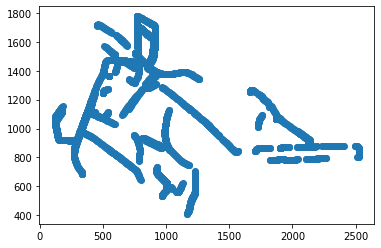

Poses extraction complete.


In [15]:
start = chunk1_start
end = chunk1_end

print(f"Processing scenes from {start} to {end}.")

all_poses = []
all_scene_poses = [None] * n_scenes
for i in tqdm(range(start, end)):
    scene_poses = []
    scene = nusc.scene[i]
    first_sample_token = scene['first_sample_token']
    pose_first, next_sample_token = get_global_lidar_pose_from_token(first_sample_token)
    all_poses.append(pose_first)
    scene_poses.append(pose_first)
    
    while next_sample_token != '':    
        pose_next, next_sample_token = get_global_lidar_pose_from_token(next_sample_token)    
        all_poses.append(pose_next)
        scene_poses.append(pose_next)
    all_scene_poses[i] = scene_poses    
    
print(f"Loading complete. Found {len(all_poses)} poses.")    
visualize_poses(all_poses)
np.save(poses_out, all_poses)
print(f"Poses extraction complete.")

## Convert the images to spherical data

In [17]:
def progresser_images(sample, grid, auto_position=True, write_safe=False, blocking=True, progress=False):    
    sample_sphere = ImageSphere(sample)
    return sample_sphere.sampleUsingGrid(grid)

def progresser_color_images(sample, grid, auto_position=True, write_safe=False, blocking=True, progress=False):    
    sample_sphere = ColorImageSphere(sample)
    return sample_sphere.sampleUsingGrid(grid)

def get_sampled_image_sphere_from_token(sample_token):
    sample = nusc.get('sample', sample_token)
    pointsensor = nusc.get('sample_data', sample['data'][lidar_string])
    pc = SamplingPointCloud.from_bw(bw, scale)

    for cam_str in all_cam_strings:          
        cam = nusc.get('sample_data', sample['data'][cam_str])
        im = Image.open(osp.join(dataset_path, cam['filename']))        

        # Transform pointcloud into the camera frame
        pc = transform_from_pcl_to_cam(nusc, pointsensor, cam, pc)
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]

        # Project the points onto the image plane
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        intrinsics = np.array(cs_record['camera_intrinsic'])
        points, mask = project_pc_on_cam(pc, intrinsics, depths, im)
        filtered_points = points[:, mask]
        
        # Sample the intensity values from the image
        # and transform back into the LiDAR frame.
        pc = sample_mono_from_image(im, pc, mask, points) 
        pc = transform_from_cam_to_pcl(nusc, pointsensor, cam, pc) 
    
    # Scale back to the original value but only use xyz.
    cloud = pc.points.T
    cloud[:,0:3] = cloud[:,0:3] / scale
    
    return cloud / scale, sample['next']

def crop_image(im):
    width, height = im.size   # Get dimensions

    new_height = 562
    new_width = 1000
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    return im.crop((left, top, right, bottom))

def get_sampled_color_image_sphere_from_token(sample_token):
    sample = nusc.get('sample', sample_token)
    pointsensor = nusc.get('sample_data', sample['data'][lidar_string])
    pc = ColorSamplingPointCloud.from_bw(bw, scale)

    for cam_str in all_cam_strings:                  
        cam = nusc.get('sample_data', sample['data'][cam_str])
        im = Image.open(osp.join(dataset_path, cam['filename']))
#         im.show()
                
        # Transform pointcloud into the camera frame
        pc = transform_from_pcl_to_cam(nusc, pointsensor, cam, pc)
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]

        # Project the points onto the image plane
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        intrinsics = np.array(cs_record['camera_intrinsic'])
        points, mask = project_pc_on_cam(pc, intrinsics, depths, im)
        filtered_points = points[:, mask]
        
        # Sample the intensity values from the image
        # and transform back into the LiDAR frame.
        pc = sample_color_from_image(im, pc, mask, points) 
        pc = transform_from_cam_to_pcl(nusc, pointsensor, cam, pc) 
    
    # Scale back to the original value but only use xyz.
    cloud = pc.points.T
    cloud[:,0:3] = cloud[:,0:3] / scale
    return cloud, sample['next']

def get_calib(sample_token):
    sample = nusc.get('sample', sample_token)
    pointsensor = nusc.get('sample_data', sample['data'][lidar_string])    

    all_cams = {}
    for cam_str in all_cam_strings:                  
        cam = nusc.get('sample_data', sample['data'][cam_str])
        all_cams[cam_str] = cam
    return pointsensor, all_cams

def get_sampled_color_image_sphere_from_token_with_calib(sample_token, lidar_sensor, all_cams):
    sample = nusc.get('sample', sample_token)
    pointsensor = nusc.get('sample_data', sample['data'][lidar_string])
    pc = ColorSamplingPointCloud.from_bw(bw, scale)

    for cam_str in all_cam_strings:                  
        cam = nusc.get('sample_data', sample['data'][cam_str])
        im = Image.open(osp.join(dataset_path, cam['filename']))
                
        # Transform pointcloud into the camera frame
        pc = transform_from_pcl_to_cam(nusc, lidar_sensor, all_cams[cam_str], pc)
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]

        # Project the points onto the image plane
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        intrinsics = np.array(cs_record['camera_intrinsic'])
        points, mask = project_pc_on_cam(pc, intrinsics, depths, im)
        filtered_points = points[:, mask]
        
        # Sample the intensity values from the image
        # and transform back into the LiDAR frame.
        pc = sample_color_from_image(im, pc, mask, points) 
        pc = transform_from_cam_to_pcl(nusc, lidar_sensor, all_cams[cam_str], pc) 
    
    # Scale back to the original value but only use xyz.
    cloud = pc.points.T
    cloud[:,0:3] = cloud[:,0:3] / scale
    return cloud, sample['next']

In [ ]:
start = chunk1_start
end = chunk1_end

print(f"Processing scenes from {start} to {end}.")

all_sph_images = []
for i in tqdm(range(start, end)):    
    scene = nusc.scene[i]
    first_sample_token = scene['first_sample_token']
    pc, next_sample_token = get_sampled_image_sphere_from_token(first_sample_token)        
    all_sph_images.append(pc)    
    
    while next_sample_token != '':    
        pc, next_sample_token = get_sampled_image_sphere_from_token(next_sample_token)    
        all_sph_images.append(pc)
    
print(f"Loading complete. Found {len(all_sph_images)} images.")
print(f"Computing features now...")    
grid, _ = DHGrid.CreateGrid(bw)
img_features = process_map(partial(progresser_images, grid=grid), all_sph_images, max_workers=8)

filename = f"{export_ds}/images.npy"
np.save(filename, img_features)
print(f"Wrote sph mono image features to {filename}.")

In [21]:
## start = chunk1_start
start = chunk2_start
end = chunk2_start+10

print(f"Processing scenes from {start} to {end}.")
scale = 123
all_color_sph_images = []
runtime = 0
for i in tqdm(range(start, end)):    
    scene = nusc.scene[i]
    first_sample_token = scene['first_sample_token']
    lidar_sensor, all_cams = get_calib(first_sample_token)
    
    pc, next_sample_token = get_sampled_color_image_sphere_from_token(first_sample_token)        
    all_color_sph_images.append(pc)    
    
    while next_sample_token != '':    
#         pc, next_sample_token = get_sampled_color_image_sphere_from_token_with_calib(next_sample_token, lidar_sensor, all_cams)    
        start_time = time.time() * 1000
        pc, next_sample_token = get_sampled_color_image_sphere_from_token(next_sample_token)    
        executionTime = (time.time() * 1000 - start_time)
        runtime = runtime + executionTime
        all_color_sph_images.append(pc)
    
print(f"Loading complete. Found {len(all_color_sph_images)} images.")
print(f"It took {runtime / len(all_color_sph_images)} ms.")
print(f"Computing features now...")
grid, _ = DHGrid.CreateGrid(bw)

start_time = time.time() * 1000
color_img_features = process_map(partial(progresser_color_images, grid=grid), all_color_sph_images, max_workers=8, chunksize=100)
executionTime = (time.time() * 1000 - start_time)
print(f"It took {executionTime / len(all_color_sph_images)} ms.")

# filename = f"{export_ds}/color_images_test.npy"
# np.save(filename, color_img_features)
# print(f"Wrote sph color image features to {filename}.")

Processing scenes from 283 to 293.


  0%|          | 0/10 [00:00<?, ?it/s]

Loading complete. Found 401 images.
It took 151.14681679590086 ms.
Computing features now...


  0%|          | 0/401 [00:00<?, ?it/s]

It took 225.83812258903524 ms.


In [10]:
i=0
cur_color_image = color_img_features[i]
cur_color_image = np.reshape(cur_color_image, (3, -1)).T
pc = SamplingPointCloud.from_bw(bw, 1)
points_xyz = pc.points.T[:,0:3]
points_xyzrgb = np.column_stack((points_xyz, cur_color_image[:, 0:3]))
visualize_pointcloud(points_xyzrgb)

## Convert the pointclouds to spherical data

In [6]:
def progresser_lidar(sample, grid, auto_position=True, write_safe=False, blocking=True, progress=False):    
    sample_sphere = Sphere(sample)
    return sample_sphere.sampleUsingGrid(grid, True)

def writeRawPointCloud(cloud, filename):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud[:, 0:3])
    colors = mapIntensityToRGB(cloud[:, 3])
    pcd.colors = o3d.utility.Vector3dVector(colors[:,0:3])
    o3d.io.write_point_cloud(filename, pcd)
    
def get_data_from_token(sample_token):
    sample = nusc.get('sample', sample_token)
    pointsensor = nusc.get('sample_data', sample['data'][lidar_string])
    # Load a single lidar point cloud.
    pcl_path = osp.join(dataset_path, pointsensor['filename'])
    pc = LidarPointCloud.from_file(pcl_path)    
    return pc.points.T, sample['next']

In [7]:
def get_semantic_point_cloud_from_token(sample_token):
    sample = nusc.get('sample', sample_token)
    pointsensor = nusc.get('sample_data', sample['data'][lidar_string])
    # Load a single lidar point cloud.
    pcl_path = osp.join(dataset_path, pointsensor['filename'])
    pc = LidarPointCloud.from_file(pcl_path)
    points_xyzi = pc.points.T
    
    # Load the semantic segmentation.
    sample_data_token = sample['data'][lidar_string]
    lidarseg_labels_filename = osp.join(nusc.dataroot, nusc.get('lidarseg', sample_data_token)['filename'])
    points_label = np.fromfile(lidarseg_labels_filename, dtype=np.uint8)  # [num_points]

    # Combine the two.
    return np.column_stack((points_xyzi, points_label)), sample['next']

def combine_pointclouds(pointclouds, poses):
    n_data = len(poses)    
    pivot = n_data // 2  
    T_G_L_pivot = poses[pivot]
    T_L_pivot_G = np.linalg.inv(T_G_L_pivot)

    acc_points = pointclouds[pivot]
    for i in range(0, n_data):
        if i == pivot:
            continue
        T_G_L = poses[i]
        T_L_pivot_L = T_L_pivot_G @ T_G_L

        points = Utils.transform_pointcloud(pointclouds[i], T_L_pivot_L)
        acc_points = np.append(acc_points, points, axis=0)
                        
    return acc_points, pivot

def combine_every_nth_point_cloud(pointclouds, poses, n=3):
    n_poses = len(poses)    
    
    # Generate combinations.
    combined = []
    pivot_indices = []
    for i in range(0, n_poses, 1):
        if i+3 >= n_poses:
            break
            
        indices = np.arange(i, i+3, 1)        
        local_clouds = []
        local_poses = []
        for idx in indices:        
            local_clouds.append(pointclouds[idx])
            local_poses.append(poses[idx])
        acc_points, pivot = combine_pointclouds(local_clouds, local_poses)
        combined.append(acc_points)
        pivot_indices.append(indices[pivot])
    return combined, pivot_indices

In [8]:
start = chunk1_start
end = chunk1_end

# start = n_scenes-10
# end = n_scenes

print(f"Processing scenes from {start} to {end}.")

all_sem_clouds = []
for i in tqdm(range(start, end)):
    scene_clouds = []
    scene = nusc.scene[i]
    first_sample_token = scene['first_sample_token']
    pc, next_sample_token = get_semantic_point_cloud_from_token(first_sample_token)
    all_sem_clouds.append(pc)
    
    while next_sample_token != '':            
        pc, next_sample_token = get_semantic_point_cloud_from_token(next_sample_token)        
        all_sem_clouds.append(pc)   

# This is the code for combining/accumulating multiple clouds to one pointcloud
# all_pivots = []
# for i in tqdm(range(start, end)):
#     scene_clouds = []
#     scene = nusc.scene[i]
#     first_sample_token = scene['first_sample_token']
#     pc, next_sample_token = get_semantic_point_cloud_from_token(first_sample_token)
#     scene_clouds.append(pc)
    
#     while next_sample_token != '':    
#         pc, next_sample_token = get_semantic_point_cloud_from_token(next_sample_token)    
#         scene_clouds.append(pc)   
    
#     combined_clouds, pivot_indices = combine_every_nth_point_cloud(scene_clouds, all_scene_poses[i], 3)
#     all_sem_clouds.append(combined_clouds)
#     all_pivots.append(pivot_indices)

print(f"Loading complete. Found {len(all_sem_clouds)} clouds.")    
print(f"Computing features...")    
grid, _ = DHGrid.CreateGrid(bw)

start_time = time.time() * 1000
sem_features = process_map(partial(progresser_lidar, grid=grid), all_sem_clouds, max_workers=8, chunksize=100)
executionTime = (time.time() * 1000 - start_time)
print(f"It took {executionTime / len(all_sem_clouds)} ms.")

# filename = f"{export_ds}/clouds1.npy"
# np.save(filename, sem_features)
# print(f"Wrote sph cloud features to {filename}.")

Processing scenes from 0 to 283.


  0%|          | 0/283 [00:00<?, ?it/s]

Loading complete. Found 11230 clouds.
Computing features...


  0%|          | 0/11230 [00:00<?, ?it/s]

It took 116.40371095924004 ms.


In [14]:
# print(f"It took {executionTime / len(all_sem_clouds)} ms.")
n_features = len(sem_features)
for i in range(n_features):
  sem_features[i] = sem_features[i][[0, 2],:,:]

(2, 240, 240)

In [9]:
print(all_sem_clouds[0][0:2])
np.random.shuffle(all_sem_clouds)
print(all_sem_clouds[0][0:2])

[[-0.44698834 -0.32775307 -0.28538856  1.         31.        ]
 [-3.2120266  -0.18916991 -1.8257709  10.         24.        ]]
[[-2.7298481  -0.12322364 -1.617994   27.         27.        ]
 [-2.848908   -0.12197054 -1.5995693  29.         27.        ]]


In [10]:
n_scans = len(all_sem_clouds)
n_scans = 1000
for i in range(0, n_scans):
    filename = f"{export_ds}/raw/10/scan{i}.npy"
    np.save(filename, all_sem_clouds[i])

In [12]:
i = 4110
cur_sem_cloud = sem_features[i]
cur_sem_cloud = np.reshape(cur_sem_cloud, (3, -1)).T

pc = SamplingPointCloud.from_bw(bw, 1)
points_xyz = pc.points.T[:,0:3]
points_xyzi = np.column_stack((points_xyz, cur_sem_cloud[:,0]))
points_xyzl = np.column_stack((points_xyz, cur_sem_cloud[:, 2]))

visualize_pointcloud(points_xyzi)

In [13]:
i = 21
cur_sem_cloud = sem_features[i]
# cur_image = img_features[i]
cur_color_image = color_img_features[i]

cur_sem_cloud = np.reshape(cur_sem_cloud, (3, -1)).T
# cur_image = np.reshape(cur_image, (1, -1)).T
cur_color_image = np.reshape(cur_color_image, (3, -1)).T


pc = SamplingPointCloud.from_bw(bw, 1)
points_xyz = pc.points.T[:,0:3]
points_xyzi = np.column_stack((points_xyz, cur_sem_cloud[:,2]))
# points_xyzp = np.column_stack((points_xyz, cur_image))
points_xyzl = np.column_stack((points_xyz, cur_sem_cloud[:, 2]))
points_xyzrgb = np.column_stack((points_xyz, cur_color_image[:, 0:3]))

visualize_pointcloud(points_xyzi)
# visualize_pointcloud(points_xyzp)
# visualize_pointcloud(points_xyzl)
visualize_pointcloud(points_xyzrgb)
# visualize_on_top(points_xyzrgb, points_xyzi)

In [74]:
# Write pointclouds
write_pointcloud(points_xyzrgb, '/tmp/sph_image.pcd')
write_pointcloud(points_xyzi, '/tmp/sph_cloud.pcd')

# Validation Set Count

In [8]:
def get_next_token(sample_token):
    sample = nusc.get('sample', sample_token)    
    return sample['next']


start = 700
end = 850

print(f"Processing scenes from {start} to {end}.")

n_clouds = 0
for i in tqdm(range(start, end)):
    scene_clouds = []
    scene = nusc.scene[i]
    first_sample_token = scene['first_sample_token']
    next_sample_token = get_next_token(first_sample_token)
    n_clouds = n_clouds + 1
    
    while next_sample_token != '':    
        next_sample_token = get_next_token(next_sample_token)    
        n_clouds = n_clouds + 1
        
print(f'We have {n_clouds} clouds in the validation set.')

Processing scenes from 700 to 850.



We have 6053 clouds in the validation set.
